# Portfolio Optimization

#### **Import Packages**

In [19]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt
from fredapi import Fred

## Ticker definition and Time Frame

#### **Ticker Selection**

In [20]:
tickers = ['CVS', 'BABA', 'EVO.ST', 'TUI1.DE']

#### **Set End Date to today and Start Date from 5 years ago**

In [21]:
end_date = datetime.today()
start_date = end_date - timedelta(days = 5*365)
print(start_date)

2020-01-07 19:29:38.070732


## Download Adjusted Close Prices

#### **Create empty DataFrame**

In [22]:
adj_close_df = pd.DataFrame()

#### **Download Close Prices for each ticker**

In [23]:
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [24]:
print(adj_close_df)

                  CVS        BABA      EVO.ST    TUI1.DE
Date                                                    
2020-01-08  62.451134  210.532761  290.699554  28.418802
2020-01-09  62.623032  214.183289  290.699554  28.561611
2020-01-10  61.978409  216.163071  309.085693  28.405819
2020-01-13  62.537090  222.585281  304.116455  27.886518
2020-01-14  63.456760  218.731964  304.613373  27.873535
...               ...         ...         ...        ...
2024-12-27  44.490002   85.059998  853.000000   8.362000
2024-12-30  43.939999   84.129997  852.799988   8.362000
2024-12-31  44.889999   84.790001         NaN        NaN
2025-01-02  44.220001   84.949997  868.799988   8.368000
2025-01-03  45.770000   85.540001  875.400024   8.106000

[1256 rows x 4 columns]


### Calculate lognormal Returns

#### **Calculate the lognormal returns for each ticker and Drop missing**

In [25]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

## Covariance Matrix

#### **Calculate covariance matrix using annualized log returns**

In [26]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

              CVS      BABA    EVO.ST   TUI1.DE
CVS      0.089269  0.015011  0.013684  0.036020
BABA     0.015011  0.232038  0.042110  0.054826
EVO.ST   0.013684  0.042110  0.209168  0.057507
TUI1.DE  0.036020  0.054826  0.057507  0.401094


## Vizualizace Kovariační Matice

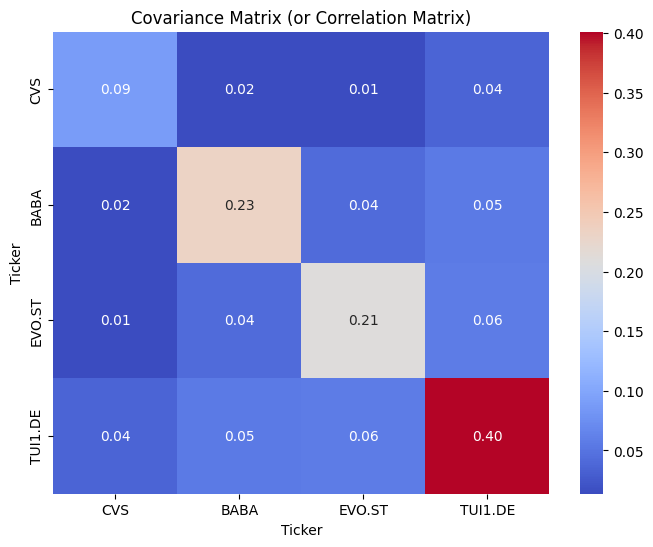

In [27]:
matrix = cov_matrix  # Nebo použijte correlation_matrix pro korelační matici

# Vytvoření heatmapy
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Covariance Matrix (or Correlation Matrix)")
plt.xlabel("Ticker")
plt.ylabel("Ticker")
plt.show()

## Define Portfolio Performance Metrics

In [28]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

## Portfolio Optimization

set risk free rate

In [29]:
risk_free_rate = 0.02


#### Set Risk free rate based on a treasury API

In [30]:
fred = Fred(api_key='73bf9caaa3bc8dcde51bd1d08eaf83d9')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

0.043899999999999995


#### **Define the function to minimize negative Sharpe Ratio**

In [31]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

#### **Set the constraints and bounds**

In [32]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]

#### **set the initial weights**

In [33]:
initial_weights = np.array([1/len(tickers)]*len(tickers))

## Optimize results to Maximize Sharpe Ratio

In [34]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

## Get Optimal Weights

In [35]:
optimal_weights = optimized_results.x
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
CVS: 0.4000
BABA: 0.2000
EVO.ST: 0.4000
TUI1.DE: 0.0000
Expected Annual Return: 0.0201
Expected Volatility: 0.2656
Sharpe Ratio: -0.0895


## Display Plot of the portfolio

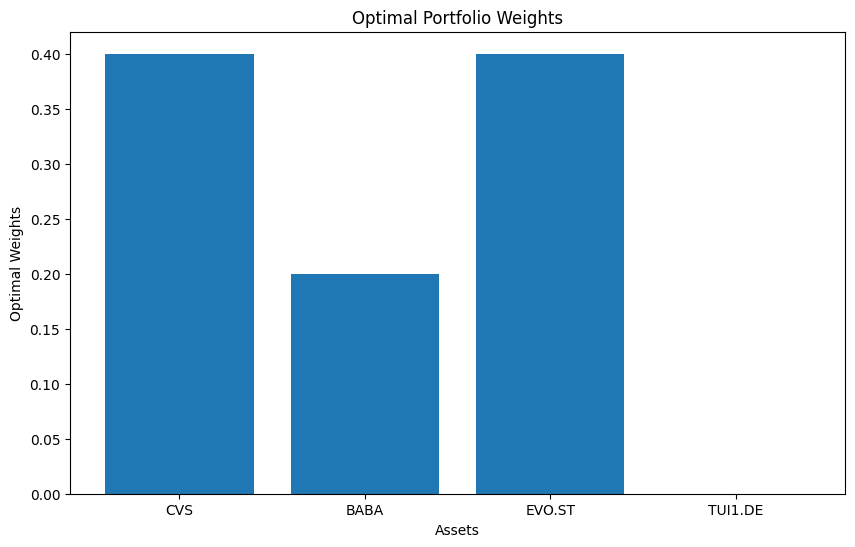

In [36]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()